In [1]:
#source
#region

#import
#region
import math
from sympy import *
import matplotlib.pyplot as plt
from numpy import linspace
import numpy as np
from sympy.codegen.cfunctions import log10
from sympy.abc import x,t,y
from collections import OrderedDict
from operator import itemgetter, attrgetter
from sympy.plotting import plot
#endregion


#mode
#region
symbolicMode = "symbolic"
numericMode = "numeric"
autoMode = "auto"
#endregion


#symbol declaration
#region
x, y, z, t = symbols('x y z t')
k, m, n = symbols('k m n', integer=True)
f, g, h = symbols('f g h', cls=Function)
#endregion


#input, output
#region
inputPath_1 = "input1.txt"

outputPath_1 = "output1.txt"

def ReadInput(file):
    f = file.readline()
    (lowT, upT) = map(lambda s: N(s), file.readline().split(","))
    (lowX, upX) = map(lambda s: N(s), file.readline().split(","))
    (t0, x0) = map(lambda s: N(s), file.readline().split(","))
    epsilon = N(file.readline())
    return (f, lowT, upT, lowX, upX, t0, x0, epsilon)

#geting M,L,H,T,N, ...
#region
def GetM(f, lowT, upT, lowX, upX):
    #not implemented
    return 5
def GetL(f, lowT, upT, lowX, upX):
    #not implemented
    return 5
def MaxDerivative(arr):
    n = f.length()
    if(n > 1):
        L = f[1] - f[0]
    else:
        raise ValueError("array too small !")
    for i in range(n):
        delta = f[i + 1] - f[i]
        if(delta > L):
            L = delta
    return L

def GetN(M, L, deltaT, deltaX, epsilon):
    h = deltaT * L
    N = 1
    error = M * deltaT
    while error > epsilon:
        N+=1
        error = error * h / N
    return N

#endregion


#main loop (integrate)
#region
def NumericIntegrate(f, xn, x0, segmentLength, epsilon):
    n = (int) (len(xn)/2)
    segmentLength /=2
    maxError = -1
    loop = 0
    while abs(maxError) > epsilon:
        loop += 1
        maxError = -1

        integral = 0
        for i in range(n, 0, -1):
            integral = integral - segmentLength * (f.subs([(t, xn[i][0]), (x, xn[i][1])]) + f.subs([(t, xn[i - 1][0]), (x, xn[i - 1][1])]))
            newValue = x0 + integral
            error = abs(xn[i - 1][1] - newValue)
            xn[i - 1][1] = newValue
            if(error > maxError): maxError = error

        integral = 0
        for i in range(n, 2 * n):
            integral = integral + segmentLength * (f.subs([(t, xn[i][0]), (x, xn[i][1])]) + f.subs([(t, xn[i + 1][0]), (x, xn[i + 1][1])]))
            newValue = x0 + integral
            error = abs(xn[i + 1][1] - newValue)
            xn[i + 1][1] = x0 + integral
            if(error > maxError): maxError = error

    return xn

def Trapezoid(f, firstIndex, lastIndex):
    f = f[firstIndex:lastIndex + 1]
    return (sum(f) - f[0] / 2 - f[f.length() - 1] / 2) / varRange
        

def SymbolicIntegrate(f, t0, x0, N):
     xn = x0
     for i in range(0,N):
        xn = x0 + integrate(f.replace(x,xn), (t,t0,t))
     return xn


#endregion


#plot
#region
def PlotPairs(pairList):
    t,x = zip(*pairList)
    plt.scatter(t,x)
    plt.show()

def PlotSymbol(symbolOutput):
    func, interval = symbolOutput
    #t = linspace(interval[0], interval[1], 1000)
    #func = t**3/3 + t**7/67
    plot((func, (t, interval[0], interval[1])))
    
def PlotBoth(symbolOutput, pairList):
    t1, x1 = zip(*pairList)
    plt.scatter(t1,x1)

    #Why(symbolOutput)
    func, interval = symbolOutput
    t_vals = linspace(interval[0], interval[1], 1000)
    lam_x = lambdify(t, func, modules=['numpy'])
    x_vals = lam_x(t_vals)
    plt.plot(t_vals, x_vals)

def Plot(f, interval):
    t_vals = linspace(interval[0], interval[1], 1000)
    lam_x = lambdify(t, f, modules = ['numpy'])
    x_vals = lam_x(t_vals)
    plt.plot(t_vals, x_vals)
    #plt.show()
#endregion

#Program
#region
def Pica1(f, lowT, upT, lowX, upX, t0, x0, M, L, epsilon, deltaT = None):
    
    deltaX = min(x0 - lowX, upX - x0)
    if deltaT is None:
        deltaT = min(deltaX / M, 1 / (2 * L), t0 - lowT, upT - t0)

    N = GetN(M, L, deltaT, deltaX, epsilon)
    xn = SymbolicIntegrate(f, t0, x0, N)

    t1 = float(t0-deltaT)
    t2 = float(t0+deltaT)
    return (xn, (t1,t2))

def Pica2(f, lowT, upT, lowX, upX, t0, x0, M, L, epsilon, deltaT = None, length = 69):
    
    deltaX = min(x0 - lowX, upX - x0)
    if deltaT is None:
        deltaT = min(deltaX / M, 1 / (2 * L), t0 - lowT, upT - t0)
    xn = []
    segmentLength = 2 * deltaT / length
    n = (int)(length / 2)
    for i in range(-n, n + 1):
        xn.append([t0 + i * segmentLength, x0])

    xn = NumericIntegrate(f, xn, x0, segmentLength, epsilon)

    return xn

def Pica(filename, length = None, M = None, L = None, deltaT = None):
    try:
        file = open(filename, "r")
        (f, lowT, upT, lowX, upX, t0, x0, epsilon) = ReadInput(file)
        f = sympify(f)
    except:
        raise ValueError("invalid Pica input")
    file.close()
    
    if M is None:
        M = GetM(x, lowT, upT, lowX, upX)
    else:
        if M < 0:
            raise ValueError("invalid Pica input")
        
        
    if L is None:
        L = GetL(x, lowT, upT, lowX, upX)
    else:
        if L < 0:
            raise ValueError("invalid Pica input")
    
    if length is None:
        return Pica1(f, lowT, upT, lowX, upX, t0, x0, M, L, epsilon, deltaT)
    return Pica2(f, lowT, upT, lowX, upX, t0, x0, M, L, epsilon, deltaT, length)


(1.37786596119929e-6*t**18 - 1.24007936507937e-5*t**16 + 9.92063492063492e-5*t**14 - 0.000694444444444444*t**12 + 0.00416666666666667*t**10 - 0.0208333333333333*t**8 + 0.0833333333333333*t**6 - 0.25*t**4 + 0.5*t**2 + 1.0, (-0.4, 0.4))


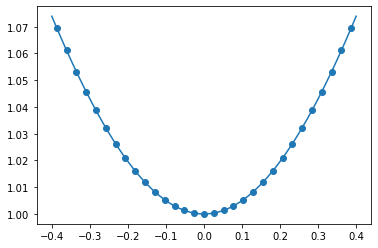

In [2]:
filename = "input2.txt"

result = Pica(filename, M = 2.5, L = 1)
result1 = Pica(filename, M = 2.5, L = 1, length = 31)

print(result)
PlotBoth(result, result1)

(t**12/720 + t**10/120 + t**8/24 + t**6/6 + t**4/2 + t**2, (-0.1, 0.1))


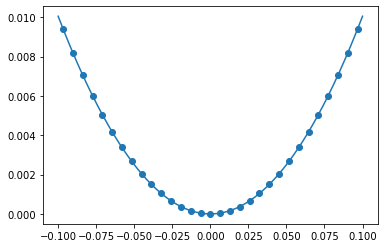

In [3]:
filename = "input3.txt"

result = Pica(filename)
result1 = Pica(filename, length = 31)

print(result)
PlotBoth(result, result1)

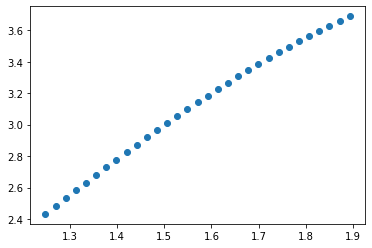

In [4]:
filename = "input4.txt"

#result = Pica(filename, M = 15, L = 1.5)
result1 = Pica(filename, length = 31, M = 15, L = 1.5)

PlotPairs(result1)
#print(result)
#PlotBoth(result, result1)

(t**127/73470070892564531648651737762668646838667587109375 + 16*t**123/2026784215040199076929988222801832975206549921875 + 10553706344*t**119/4829540810131428362478795106110697038362048222576953125 + 61104138904*t**115/157456899195622494003944412172151034402956883132421875 + 650561249388838892*t**111/12964665628112748090971470147115940720535741718546508984375 + 9490819712207899544*t**107/1868480467901609556809699339309718146540082662093041640625 + 36865010961074750285127964*t**103/87420847886874420674270964006886181949542654583772966961015625 + 276709867858696153597970708*t**99/9336207055879792499193986447337359237329798062344685791953125 + 1098374990496523336216185539914*t**95/608750338795920819495064405212260385319100706039674607875953125 + 1154841614105888864160615112*t**91/11926966246191090357238098612816996031076045252313909140625 + 151840226964000744336610309276*t**87/32687751448352285001045953780621525386267754790407570765625 + 773348017207984451375671084*t**83/38371928539793418

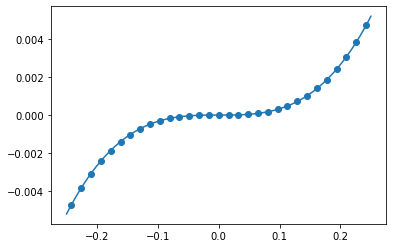

In [6]:
filename = "input1.txt"

result = Pica(filename, M = 2, L = 1)
result1 = Pica(filename, length = 31, M = 2, L = 1)

print(result)
PlotBoth(result, result1)
#Plot(sin(10*t) + cos(10*t), result[1])
#plt.show()